# This code identifies hot and cold spots using LST and Airtemp 2025

### 0. Libraries

In [2]:
!pip install rasterio
!pip install geopandas
!pip install numpy
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 97.9 MB/s eta 0:00:00


In [3]:
#libraries
import os
import geopandas as gpd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
from matplotlib.colors import ListedColormap

#LST Analysis (updated)

Raw LST stats:
Min: 30.0
Max: 46.0
Mean: 38.28642807017544

Quartiles:
Q1=35.00, Q2=39.00, Q3=42.00


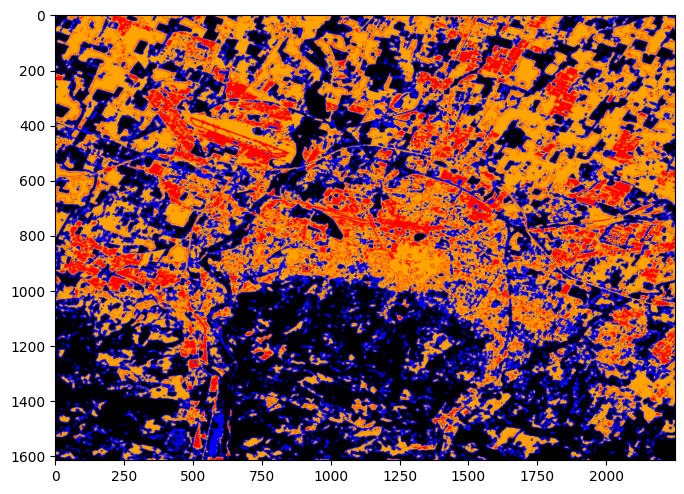

Output saved as: /content/drive/MyDrive/Climate Shelter_Talea/climate-shelters_2025/data/LST2025/LST_hot_cold_classified.tif


In [4]:

# === Input and Output Paths ===
tif_path = "/data/Climate Shelter_Talea/climate-shelters_2025/data/LST2025/LST_10m_prediction_Bologna2025.tif"   # Change PATH
output_path = "/data/Climate Shelter_Talea/climate-shelters_2025/data/LST2025/LST_hot_cold_classified.tif"


# === Read Raster ===
with rasterio.open(tif_path) as src:
    lst = src.read(1).astype(float)
    profile = src.profile

# === Handle invalid pixels ===
lst[lst <= 0] = np.nan   # remove zero/no-data
non_nan = lst[~np.isnan(lst)]

print("Raw LST stats:")
print("Min:", np.nanmin(lst))
print("Max:", np.nanmax(lst))
print("Mean:", np.nanmean(lst))

# === Quartile thresholds ===
q25 = np.nanpercentile(non_nan, 25)
q50 = np.nanpercentile(non_nan, 50)
q75 = np.nanpercentile(non_nan, 75)
print(f"\nQuartiles:\nQ1={q25:.2f}, Q2={q50:.2f}, Q3={q75:.2f}")

# === Classification ===
classified = np.zeros_like(lst, dtype=np.uint8)
classified[(lst <= q25)] = 1  # Cold Spot
classified[(lst > q25) & (lst <= q50)] = 2
classified[(lst > q50) & (lst <= q75)] = 3
classified[(lst > q75)] = 4   # Hot Spot
classified[np.isnan(lst)] = 0

# === Save ===
profile.update(dtype=rasterio.uint8, count=1, nodata=0)
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(classified, 1)

# === Visualize ===
colors = ['black', 'blue', 'green', 'orange', 'red']
cmap = ListedColormap(colors)

plt.figure(figsize=(8,6))
show(classified, cmap=cmap)

print("Output saved as:", output_path)


### 1. Reprojecting GeoTIFF

In [5]:
# Function to reproject GeoTIFF file to EPSG 4326
def reproject_to_4326(input_file, output_file):
    with rasterio.open(input_file) as src:
        transform, width, height = calculate_default_transform(src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': 'EPSG:4326',
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_file, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs='EPSG:4326',
                    resampling=Resampling.nearest
                )


In [6]:
# Folder containing GeoTIFF files
folder_path = r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/Air_temperature_Bologna/Estati_22_23"

# Loop through all GeoTIFF files in the folder and reproject them
for filename in os.listdir(folder_path):
    if filename.endswith('.tif') or filename.endswith('.tiff'):
        input_file = os.path.join(folder_path, filename)
        output_file = os.path.join(folder_path, f'reprojected_{filename}')  # Change the output filename if needed
        reproject_to_4326(input_file, output_file)

### 2. Hot and Cold Spot

In [7]:
# Path to the folder containing the TIFF files
folder_path = r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/Air_temperature_Bologna/Estati_22_23/reprojected_bologna"

In [8]:
# Get a list of all TIFF files in the folder
tif_files = [f for f in os.listdir(folder_path)]

In [9]:
# Function to process a TIFF file and return the hot and cold spots
def process_tiff(tif_path):
    with rasterio.open(tif_path) as src:
        # Read the raster data as a NumPy array
        temperature_matrix = src.read(1)  # Assuming temperature is stored in the first band

        # Calculate quartiles for non-zero values
        non_zero_values = temperature_matrix[temperature_matrix != 0]
        q25 = np.percentile(non_zero_values, 25)
        q50 = np.percentile(non_zero_values, 50)
        q75 = np.percentile(non_zero_values, 75)

        # Find indices of cells of q1, q2, q3, q4
        q4_hot_spot_indices = np.argwhere((temperature_matrix > q75) & (temperature_matrix != 0))
        q3_indices = np.argwhere((temperature_matrix > q50) & (temperature_matrix < q75) & (temperature_matrix != 0))
        q2_indices = np.argwhere((temperature_matrix > q25) & (temperature_matrix < q50) & (temperature_matrix != 0))
        q1_cold_spot_indices = np.argwhere((temperature_matrix < q25) & (temperature_matrix != 0))

        return q4_hot_spot_indices, q3_indices, q2_indices, q1_cold_spot_indices

In [10]:
# Dictionary to store hot and cold spot arrays for each TIFF file
q4_hot_spot_results = {}
q3_results = {}
q2_results = {}
q1_cold_spot_results = {}

# Iterate through each TIFF file
for tif_file in tif_files:
    tif_path = os.path.join(folder_path, tif_file)

    # Process the TIFF file
    q4_hot_spot_indices, q3_indices, q2_indices, q1_cold_spot_indices = process_tiff(tif_path)

    # Store the hot and cold spot indices in the dictionaries
    q4_hot_spot_results[tif_file] = q4_hot_spot_indices
    q3_results[tif_file] = q3_indices
    q2_results[tif_file] = q2_indices
    q1_cold_spot_results[tif_file] = q1_cold_spot_indices

In [11]:
# Create a dictionary to count the occurrences of each cell position for hot and cold spots
q4_hot_cell_count = {}
q3_cell_count = {}
q2_cell_count =  {}
q1_cold_cell_count = {}

# Iterate through hot and cold spot arrays from TIFF files
#### Q4
for tif_file, hot_spot_indices in q4_hot_spot_results.items():
    for row, col in hot_spot_indices:
        cell_position = (row, col)

        # Increment the count for the cell position in hot spots
        if cell_position in q4_hot_cell_count:
            q4_hot_cell_count[cell_position] += 1
        else:
            q4_hot_cell_count[cell_position] = 1

#### Q3
for tif_file, q3_spot_indices in q3_results.items():
    for row, col in q3_spot_indices:
        cell_position = (row, col)

        # Increment the count for the cell position in hot spots
        if cell_position in q3_cell_count:
            q3_cell_count[cell_position] += 1
        else:
            q3_cell_count[cell_position] = 1

#### Q2
for tif_file, q2_spot_indices in q2_results.items():
    for row, col in q2_spot_indices:
        cell_position = (row, col)

        # Increment the count for the cell position in hot spots
        if cell_position in q2_cell_count:
            q2_cell_count[cell_position] += 1
        else:
            q2_cell_count[cell_position] = 1



#### Q1
for tif_file, cold_spot_indices in q1_cold_spot_results.items():
    for row, col in cold_spot_indices:
        cell_position = (row, col)

        # Increment the count for the cell position in cold spots
        if cell_position in q1_cold_cell_count:
            q1_cold_cell_count[cell_position] += 1
        else:
            q1_cold_cell_count[cell_position] = 1

# Create datasets for hot and cold spots that occur more than 92 times (at least half of the total days)
q4_hot_spot_dataset = [(row, col, count) for (row, col), count in q4_hot_cell_count.items() if count > 92]
q3_spot_dataset = [(row, col, count) for (row, col), count in q3_cell_count.items() if count > 92]
q2_spot_dataset = [(row, col, count) for (row, col), count in q2_cell_count.items()if count > 92]
q1_cold_spot_dataset = [(row, col, count) for (row, col), count in q1_cold_cell_count.items() if count > 92]



In [ ]:
# Load the original GeoTIFF you want to mark
original_tiff_path = r"/data/Climate Shelter_Talea/climate-shelters_2025/data/Meteoblue/Air_temperature_Bologna/Estati_22_23/reprojected_bologna/reprojected_bologna_2022060116Z.tif"
with rasterio.open(original_tiff_path) as src:
    original_data = src.read(1)
    profile = src.profile

In [ ]:
# Create arrays for marked spots
marked_data = np.empty_like(original_data, dtype=object)

In [ ]:
# Define numerical values for the classes
class_values = {
    'Q4': 4,
    'Q3': 3,
    'Q2': 2,
    'Q1': 1,
}

In [ ]:
# Mark hot spots in the q4_hot_spot_marked array
for row, col, _ in q4_hot_spot_dataset:
    marked_data[row, col] = class_values['Q4']

# Mark spots in the q3_spot_dataset array
for row, col, _ in q3_spot_dataset:
    marked_data[row, col] = class_values['Q3']

# Mark spots in the q2_spot_dataset array
for row, col, _ in q2_spot_dataset:
    marked_data[row, col] = class_values['Q2']

# Mark cold spots in the q1_cold_spot_marked array
for row, col, _ in q1_cold_spot_dataset:
    marked_data[row, col] = class_values['Q1']



In [ ]:
# Save marked hot spot and cold spot arrays as separate GeoTIFFs
#output_directory = r"data\Meteoblue\Air_temperature_Bologna\Estati_22_23\Hot_Cold_Spot" #airtemperature
output_directory = r"/data/Climate Shelter_Talea/climate-shelters_2025/data/LST2025/Hot_Cold_Spot"
output_tiff_path = os.path.join(output_directory, "hot_cold_spots.tif")
with rasterio.open(output_tiff_path, 'w', **src.profile) as dst:
    dst.write(marked_data, 1)